In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Increase network size, adding regularization, dropout, call back to improve the model

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras import models, layers, optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

# Load data from CSV using Pandas
dataset = pd.read_csv('/content/drive/MyDrive/Tree Classifier Project/TreeClassiferDataNew.csv')

# Split into input (X) and output (y) variables
X = dataset.iloc[:, 0:3]    # X is the data
y = dataset.iloc[:, 3]      # y is the label
# Using .iloc ensures that we are correctly using integer-based indexing for the DataFrame.

# One-hot encode the target labels
y = to_categorical(y)

# Convert data to numpy arrays
X = np.array(X)
y = np.array(y)

# Define a function to build the model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))

    optimizer = optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=1)

val_acc_per_fold = []
test_acc_per_fold = []
train_acc_per_fold = []

for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for the current fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Further split the validation set into validation and test sets
    X_val, X_test = X_val[:len(X_val)//2], X_val[len(X_val)//2:]
    y_val, y_test = y_val[:len(y_val)//2], y_val[len(y_val)//2:]

    # Build and compile the model
    model = build_model()

    # Define the early stopping and model checkpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath='best_model_fold.h5', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=5,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Load the best model for the current fold
    best_model = load_model('best_model_fold.h5')

    # Evaluate the best model on the training, validation, and test sets
    train_loss, train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

    train_acc_per_fold.append(train_accuracy)
    val_acc_per_fold.append(val_accuracy)
    test_acc_per_fold.append(test_accuracy)
    print(f"Fold Training Accuracy: {train_accuracy}")
    print(f"Fold Validation Accuracy: {val_accuracy}")
    print(f"Fold Test Accuracy: {test_accuracy}")

# Calculate the average performance across all folds
print(f"Average Training Accuracy: {np.mean(train_acc_per_fold)}")
print(f"Average Validation Accuracy: {np.mean(val_acc_per_fold)}")
print(f"Average Test Accuracy: {np.mean(test_acc_per_fold)}")


Epoch 1/50
20/24 [========================>.....] - ETA: 0s - loss: 1.2212 - accuracy: 0.7500
Epoch 1: val_loss improved from inf to 3.04472, saving model to best_model_fold.h5
24/24 [==============================] - 4s 41ms/step - loss: 1.1398 - accuracy: 0.7917 - val_loss: 3.0447 - val_accuracy: 0.4667 - lr: 0.0100
Epoch 2/50
16/24 [===================>..........] - ETA: 0s - loss: 1.2074 - accuracy: 0.8125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/24 [===========================>..] - ETA: 0s - loss: 1.2600 - accuracy: 0.8174
Epoch 2: val_loss improved from 3.04472 to 2.58725, saving model to best_model_fold.h5
24/24 [==============================] - 0s 12ms/step - loss: 1.2779 - accuracy: 0.8083 - val_loss: 2.5872 - val_accuracy: 0.4667 - lr: 0.0100
Epoch 3/50
17/24 [====================>.........] - ETA: 0s - loss: 1.0475 - accuracy: 0.9176
Epoch 3: val_loss improved from 2.58725 to 2.02873, saving model to best_model_fold.h5
24/24 [==============================] - 0s 11ms/step - loss: 1.1770 - accuracy: 0.8750 - val_loss: 2.0287 - val_accuracy: 0.4667 - lr: 0.0100
Epoch 4/50
17/24 [====================>.........] - ETA: 0s - loss: 1.1792 - accuracy: 0.8588
Epoch 4: val_loss improved from 2.02873 to 1.66783, saving model to best_model_fold.h5
24/24 [==============================] - 0s 10ms/step - loss: 1.1856 - accuracy: 0.8583 - val_loss: 1.6678 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 5/50
19/24 [=====================

1/1 [==============================] - 0s 445ms/step


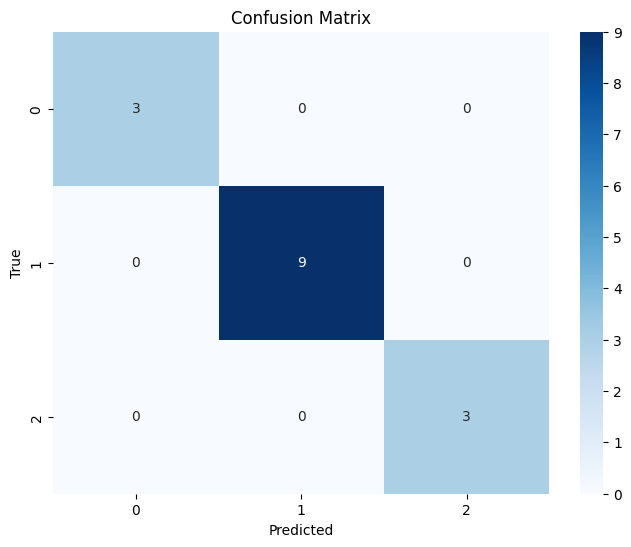

In [4]:
#Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model, X_test, and y_test are already defined and available
# Also assuming y_test is one-hot encoded and needs to be converted back to labels

# Predict the labels for the test set
y_pred = np.argmax(best_model.predict(X_test), axis=1)
# Convert the one-hot encoded y_test back to labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
